In [30]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
import functools

from networks import UnetGenerator
from datasets import loadHeat

%autosave 100

def to_img(x, data_size):
#     x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, data_size, data_size)
    return x

Autosaving every 100 seconds


In [28]:
# Define training parameters
batch_size=64
learning_rate = 5e-4
num_epochs = 2000

In [3]:
# Input image handling
data_size = 32
dataset = loadHeat(data_size, ground_truth=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Initialize U-Net (or ResNet) convolutional architecture
net = UnetGenerator(1, 1, 4, ngf=64, norm_layer=functools.partial(nn.BatchNorm2d, affine=True), use_dropout=False, gpu_ids=[]).cuda()

class Codec(nn.Module):
    # Autoencoder for MNIST images
    def __init__(self):
        super(Codec, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pad = nn.ZeroPad2d((0,1,0,1))
        self.conv3 = nn.Conv2d(32, 4, kernel_size=3, padding=1)
        
        self.encoded = None # 4x4x4
        
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1, stride=2)
        self.deconv2 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2)
        self.deconv3 = nn.ConvTranspose2d(16, 16, kernel_size=4)
        
        self.decode_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        
    def forward(self, x):
        # encoder
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        self.encoded = F.max_pool2d(self.pad(F.relu(self.conv3(x))), 2)

        # encoded representation is 8x4x4 = 128-dimensional encoding space

        # decoder
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        decoded = F.sigmoid(self.decode_conv(x))*100
        return decoded

# net = Codec().cuda()

print(net)

UnetGenerator (
  (model): UnetSkipConnectionBlock (
    (model): Sequential (
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock (
        (model): Sequential (
          (0): LeakyReLU (0.2, inplace)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (3): UnetSkipConnectionBlock (
            (model): Sequential (
              (0): LeakyReLU (0.2, inplace)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
              (3): UnetSkipConnectionBlock (
                (model): Sequential (
                  (0): LeakyReLU (0.2, inplace)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                  (2): BatchNorm2d(5

In [42]:
center_mask = torch.zeros(1,32,32).unsqueeze(0)
center_mask[:,:,:,0] = 1
center_mask[:,:,0,:] = 1
center_mask[:,:,:,-1] = 1
center_mask[:,:,-1,:] = 1

boundary_mask = 1 - center_mask

class UNet(nn.Module):
    # UNet for Heat Transport
    def __init__(self, image_size=32, max_temp=100, num_filters=64):
        super(UNet, self).__init__()

        self.max_temp = max_temp

        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=4, stride=2,padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(num_filters*2, num_filters*4, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(num_filters*4, num_filters*8, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(num_filters*8, num_filters*8, kernel_size=4, stride=2, padding=1)

        self.ebn1 = nn.BatchNorm2d(num_filters)
        self.ebn2 = nn.BatchNorm2d(num_filters*2)
        self.ebn3 = nn.BatchNorm2d(num_filters*4)
        self.ebn4 = nn.BatchNorm2d(num_filters*8)
        self.ebn5 = nn.BatchNorm2d(num_filters*8)

        self.encoded = None # 4x4x4
        
        self.deconv1 = nn.ConvTranspose2d(num_filters*8, num_filters*8, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(num_filters*8*2, num_filters*4, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(num_filters*4*2, num_filters*2, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(num_filters*2*2, num_filters, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(num_filters*2, 1, kernel_size=4, stride=2, padding=1)

        self.dbn1 = nn.BatchNorm2d(num_filters*8)
        self.dbn2 = nn.BatchNorm2d(num_filters*4)
        self.dbn3 = nn.BatchNorm2d(num_filters*2)
        self.dbn4 = nn.BatchNorm2d(num_filters)


    def forward(self, x):
        # encoder
        en_1 = F.leaky_relu(self.conv1(x), 0.2)
        en_2 = F.leaky_relu(self.ebn2(self.conv2(en_1)), 0.2)
        en_3 = F.leaky_relu(self.ebn3(self.conv3(en_2)), 0.2)
        en_4 = F.leaky_relu(self.ebn4(self.conv4(en_3)), 0.2)

        # encoded representation is (batch_size, num_filters*8, 1, 1)-dimensional encoding space
        self.encoded = self.ebn5(self.conv5(en_4))
        
        # decoder
        de_1 = self.dbn1(self.deconv1(F.relu(self.encoded)))
        de_2 = self.dbn2(self.deconv2(F.relu(torch.cat((de_1, en_4), dim=1))))
        de_3 = self.dbn3(self.deconv3(F.relu(torch.cat((de_2, en_3), dim=1))))
        de_4 = self.dbn4(self.deconv4(F.relu(torch.cat((de_3, en_2), dim=1))))
        decoded = F.tanh(self.deconv5(F.relu(torch.cat((de_4, en_1), dim=1))))
        output = (decoded + 1)*self.max_temp / 2
        output = output*Variable(boundary_mask) + x*Variable(center_mask)
        return output

net = UNet().cuda()

In [43]:
# Define physics loss
kernel = Variable(torch.Tensor(np.array([[[[0, 1/4, 0], [1/4, -1, 1/4], [0, 1/4, 0]]]]))).cuda()

def physical_loss(img):
    return F.conv2d(img, kernel).norm()

criterion = physical_loss
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [36]:
# Create output masks
center_mask = torch.zeros(dataset[0].shape).unsqueeze(0)
center_mask[:,:,:,0] = 1
center_mask[:,:,0,:] = 1
center_mask[:,:,:,-1] = 1
center_mask[:,:,-1,:] = 1

boundary_mask = torch.ones(dataset[0].shape).unsqueeze(0)
boundary_mask[:,:,:,0] = 0
boundary_mask[:,:,0,:] = 0
boundary_mask[:,:,:,-1] = 0
boundary_mask[:,:,-1,:] = 0

In [6]:
center_mask = Variable(center_mask).cuda()
boundary_mask = Variable(boundary_mask).cuda()

In [44]:
# Outer training loop
## Training loop
for epoch in range(num_epochs):
    for data in dataloader:
        img = Variable(data).cuda()
        output = net(img)
#         output = (output+1)*50
#         output = output*boundary_mask + img*center_mask
        loss = criterion(output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
#     if epoch % 10 == 0:
#         train_pic = to_img(img.cpu().data)
#         gen_pic = to_img(output.cpu().data, data_size)
#         save_image(train_pic, './decoded_mnist/image_{}_train.png'.format(epoch))
#         save_image(gen_pic, './generated_heat_fields/image_{}_gen.png'.format(epoch), scale_each=True, range=(0,100))

RuntimeError: tensors are on different GPUs

In [ ]:
## Save model

In [ ]:
# Output image handling

In [20]:
# heat = Variable(torch.Tensor(np.loadtxt('datasets/small_data/BC/0-10-20-90.csv', delimiter=','))).cuda()
heat = Variable(torch.Tensor(np.loadtxt('datasets/%d_small/BC/0-100-20-40.csv' % data_size, delimiter=','))).cuda()
truth = Variable(torch.Tensor(np.loadtxt('datasets/%d_small/field/0-100-20-40.csv' % data_size, delimiter=','))).cuda()

In [21]:
output = net(heat.unsqueeze(0).unsqueeze(0))

In [22]:
output

Variable containing:
(0 ,0 ,.,.) = 
 -0.9434 -0.9779  0.9826  ...  -0.9472 -1.0000 -0.8765
 -0.9815 -0.9994  0.4559  ...   0.4792 -0.0563  1.0000
 -0.4343 -0.9999 -0.9990  ...  -0.1499 -0.4565  0.9999
           ...             ⋱             ...          
 -0.9632 -0.9999 -0.9999  ...  -0.8612 -0.5222  0.9730
 -0.8867 -0.9999 -0.9997  ...  -0.8871 -0.6834 -0.1470
 -0.4063 -0.9645 -0.9542  ...  -0.3826 -0.3825  0.3361
[torch.cuda.FloatTensor of size 1x1x32x32 (GPU 0)]

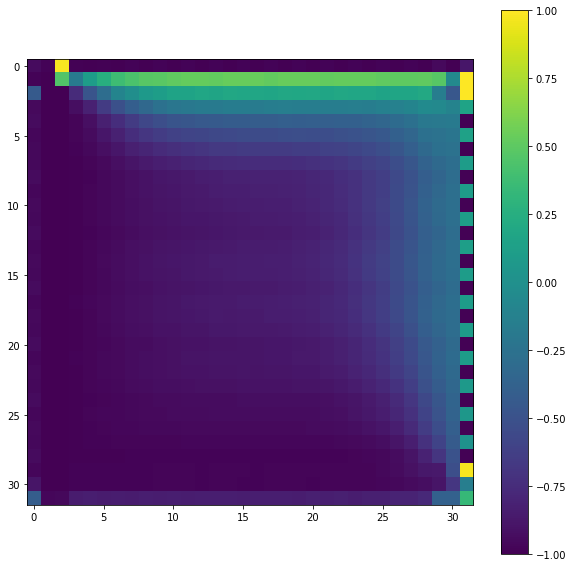

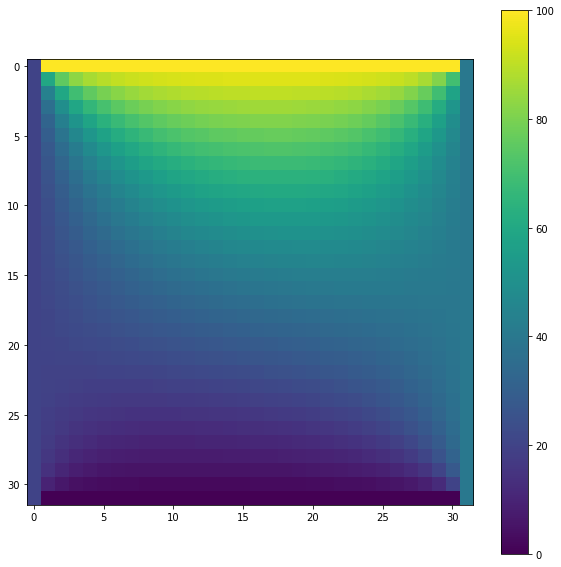

In [24]:
plt.figure(figsize=(10,10))
XX, YY = np.meshgrid(np.arange(0, data_size), np.arange(0, data_size))
# plt.contourf(XX, YY, output.cpu().data.numpy()[0,0,:,:], colorinterpolation=50, cmap=plt.cm.jet)
plt.imshow(output.cpu().data.numpy()[0,0,:,:])
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
XX, YY = np.meshgrid(np.arange(0, data_size), np.arange(0, data_size))
# plt.contourf(XX, YY, truth.cpu().data.numpy(), colorinterpolation=50, cmap=plt.cm.jet)
plt.imshow(truth.cpu().data.numpy())
plt.colorbar()
plt.show()

---

---

---

---

---

---
# Miscellaneous Tests

In [2]:
kernel_ = np.array([[0, 1/4, 0], [1/4, -1, 1/4], [0, 1/4, 0]])
kernel = Variable(torch.Tensor(kernel_))
img = Variable(torch.rand(10,10))

def physical_loss(img):
#     return F.conv2d((img.unsqueeze(0)).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0)).norm()
    return F.conv2d((img.unsqueeze(0)).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0))

In [4]:
physical_loss(img)

Variable containing:
(0 ,0 ,.,.) = 
  0.0292  0.3121 -0.2342 -0.1250 -0.2445 -0.3733 -0.2806 -0.1527
 -0.1400  0.0060  0.4090 -0.1374  0.3424  0.0427  0.4813 -0.0692
 -0.4020  0.5477 -0.7780  0.2630  0.0718  0.2802  0.2284 -0.6202
  0.1652 -0.6265  0.2452  0.3149 -0.2875 -0.3081 -0.1356  0.6590
 -0.3522  0.6148 -0.2975  0.1686 -0.2690 -0.1233  0.1784 -0.2472
 -0.0768 -0.2584  0.2547  0.2669 -0.1479  0.3965  0.1607  0.1083
 -0.4120  0.3863  0.2018 -0.5286  0.2726 -0.0041 -0.4462  0.2418
  0.5019  0.2671 -0.2837 -0.2454 -0.3699 -0.2484  0.1922  0.3512
[torch.FloatTensor of size 1x1x8x8]

In [5]:
# Heat is true ground truth solution
heat_ = np.loadtxt('datasets/32_small/field/0-10-20-90.csv', delimiter=',')
heat = Variable(torch.Tensor(heat_))
heat

Variable containing:
 20.0000  10.0000  10.0000  ...   10.0000  10.0000  90.0000
 20.0000  15.0134  13.0503  ...   34.1378  49.9750  90.0000
 20.0000  17.0032  15.0536  ...   49.8999  65.7621  90.0000
           ...               ⋱              ...            
 20.0000  13.9912  10.0765  ...   44.9228  62.7501  90.0000
 20.0000  10.0191   6.0853  ...   27.1727  44.9807  90.0000
 20.0000   0.0000   0.0000  ...    0.0000   0.0000  90.0000
[torch.FloatTensor of size 64x64]

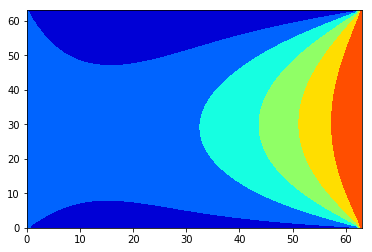

In [6]:
XX, YY = np.meshgrid(np.arange(0, 64), np.arange(0, 64))
plt.contourf(XX, YY, heat.data.numpy(), colorinterpolation=50, cmap=plt.cm.jet, vmin=0, vmax=100)
plt.show()

In [7]:
physical_loss(heat)

Variable containing:
(0 ,0 ,.,.) = 
1.00000e-03 *
  0.0072  0.0136  0.0191  ...   0.0143  0.0095  0.0038
  0.0143  0.0234  0.0329  ...   0.0257  0.0124  0.0038
  0.0191  0.0334  0.0458  ...   0.0334  0.0191  0.0076
           ...             ⋱             ...          
  0.0148  0.0229  0.0327  ...   0.0210  0.0095  0.0057
  0.0088  0.0143  0.0199  ...   0.0114  0.0081 -0.0010
  0.0038  0.0052  0.0072  ...   0.0043  0.0010 -0.0019
[torch.FloatTensor of size 1x1x62x62]

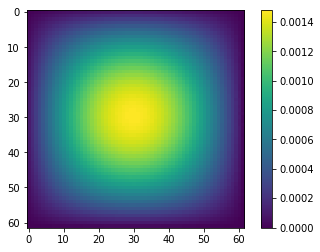

In [8]:
# Ground truth satisfies small value when kernel is applied
plt.imshow(physical_loss(heat).data.numpy()[0,0,:,:])
plt.colorbar()
plt.show()